# <span style="color:royalblue"><center> DBSCAN Y HDBSCAN </center></span>

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [63]:
X,y,c = make_blobs(500,cluster_std = 0.8, 
                   centers = 4, n_features=2,return_centers=True)
df_blobs = pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1]
})
df_centers = pd.DataFrame({
    'x1':c[:,0],
    'x2':c[:,1]
})


In [64]:
X_m,y_m = make_moons(n_samples=250, noise=0.05, random_state=42)
df_moons = pd.DataFrame({
    'x1':X_m[:,0],
    'x2':X_m[:,1]
})

### DataViz

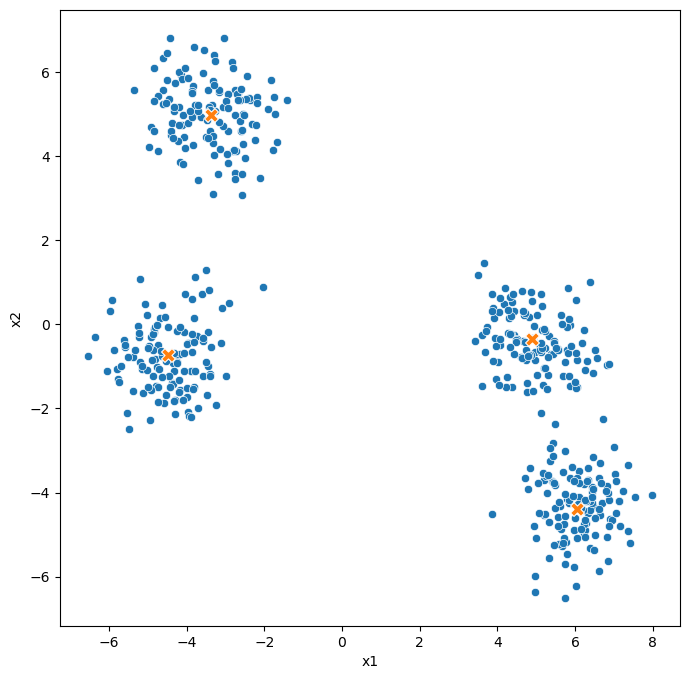

In [65]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s = 100)
plt.plot()
plt.show()

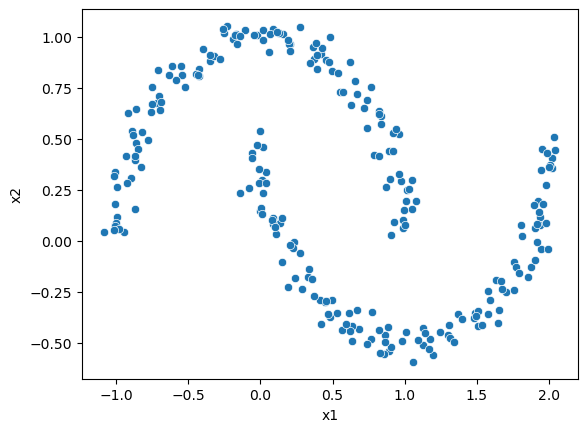

In [66]:
sns.scatterplot(data=df_moons, x='x1',y='x2')
plt.show()

Es claro que con la utilización del ```KMeans``` sería imposible conseguir el desempeño esperado, porque una luna no es esférica totalmente. Así que lo importante es usar el ```DBSCAN``` buscando el mejor resultado

### DBSCAN

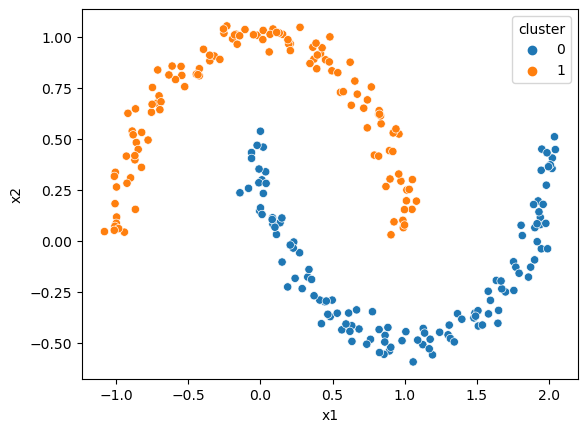

In [67]:
dbscan_cluster = DBSCAN(eps=0.3, #radio
      min_samples=3) #Número mínimo de puntos para el cluster
y_m_predict = dbscan_cluster.fit_predict(X_m)
df_moons['cluster'] = y_m_predict
sns.scatterplot(data=df_moons, x='x1',y='x2',hue='cluster')
plt.show()

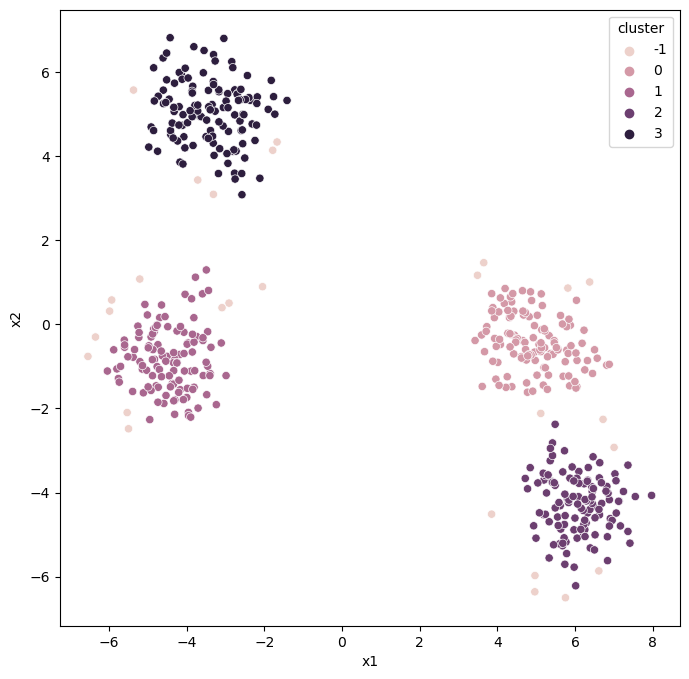

In [68]:
dbscan_circles = DBSCAN(eps=0.5,
                       min_samples=4)
y_predict = dbscan_circles.fit_predict(X)
df_blobs['cluster'] = y_predict
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2',hue='cluster')
plt.plot()
plt.show()

### ¿Cómo encontrar los hiper-parámetros si son tan sensibles para obtener los mejores resultados?

In [69]:
from sklearn.neighbors import NearestNeighbors

In [70]:
neighbors = NearestNeighbors(n_neighbors=3) #Usualmente es #Dimensiones * 2 ~4 en éste caso
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

In [71]:
distances

array([[0.        , 0.17911015, 0.2681605 ],
       [0.        , 0.12369709, 0.19447748],
       [0.        , 0.29121185, 0.30466466],
       ...,
       [0.        , 0.27857003, 0.41007447],
       [0.        , 0.05525357, 0.11578035],
       [0.        , 0.03575318, 0.23736263]])

In [72]:
indices

array([[  0, 472, 216],
       [  1, 280, 283],
       [  2,  12,   8],
       ...,
       [497, 264,  43],
       [498, 167, 134],
       [499, 354, 414]], dtype=int64)

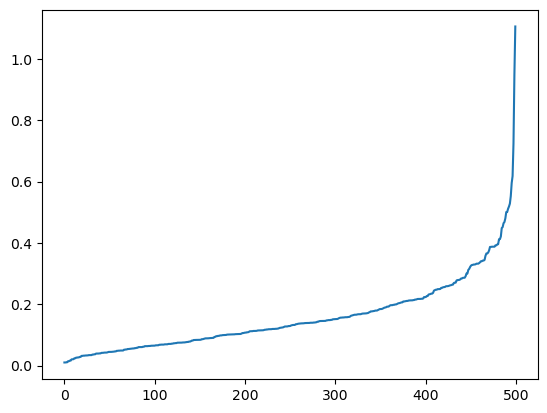

In [73]:
distances = np.sort(distances,axis=0)
distances= distances[:,1] #De la primera fila, o sea el más cercano
plt.plot(distances)

Más o menos por el algoritmo de ejecución y por un método similar al del codo, podemos ver que el rango de distancias en donde la derivada es más evidente está en un rango entre ```~ 0.2 y 0.5``` 

In [74]:
eps_values = np.arange(0.2,0.8,0.05)
min_samples = np.arange(2,10,1)

In [75]:
from itertools import product

In [76]:
dbscan_paramns = list(product(eps_values,min_samples))
sil_scores = []
for p in dbscan_paramns: 
    y_pred = DBSCAN(eps= p[0], min_samples=p[1]).fit_predict(X)
    sil_scores.append(silhouette_score(X,y_pred))

df_paramns_tunning = pd.DataFrame.from_records(dbscan_paramns, 
                                               columns = ['Eps','Min_Samples'])
df_paramns_tunning['sil_scores'] = sil_scores

In [77]:
df_paramns_tunning

,Eps,Min_Samples,sil_scores
0,0.2,2,0.013843
1,0.2,3,-0.101730
2,0.2,4,-0.264069
3,0.2,5,-0.452477
4,0.2,6,-0.601918
...,...,...,...
99,0.8,5,0.669784
100,0.8,6,0.669784
101,0.8,7,0.669784
102,0.8,8,0.703789


In [78]:
pivot_data = pd.pivot_table(df_paramns_tunning,
              values='sil_scores',index='Min_Samples',
              columns='Eps')
pivot_data

Eps,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80
Min_Samples,,,,,,,,,,,,,
2,0.013843,-0.062725,-0.131085,-0.019895,0.085667,0.214385,0.250278,0.430627,0.532044,0.458311,0.458311,0.634296,0.634296
3,-0.101730,-0.116559,-0.033610,0.161591,0.376974,0.533598,0.656790,0.680271,0.684947,0.678712,0.678712,0.634296,0.634296
4,-0.264069,-0.150397,-0.063631,0.344512,0.312574,0.504456,0.650833,0.670308,0.675211,0.655303,0.655303,0.653276,0.610727
5,-0.452477,-0.184116,-0.129189,0.154656,0.403749,0.494592,0.634289,0.665397,0.683326,0.696679,0.655303,0.653276,0.669784
6,-0.601918,-0.296871,-0.119803,0.180937,0.391188,0.583861,0.615119,0.660578,0.679496,0.693318,0.696679,0.664462,0.669784
7,-0.614791,-0.401295,-0.162043,0.004356,0.483290,0.567650,0.610368,0.642729,0.663198,0.688818,0.696659,0.696659,0.669784
8,-0.508385,-0.573144,-0.219071,0.091212,0.307868,0.420082,0.578038,0.629824,0.663198,0.686559,0.696659,0.696659,0.703789
9,-0.179863,-0.130690,-0.369043,-0.063331,0.245063,0.492438,0.557294,0.619480,0.655203,0.670821,0.681096,0.696659,0.703789


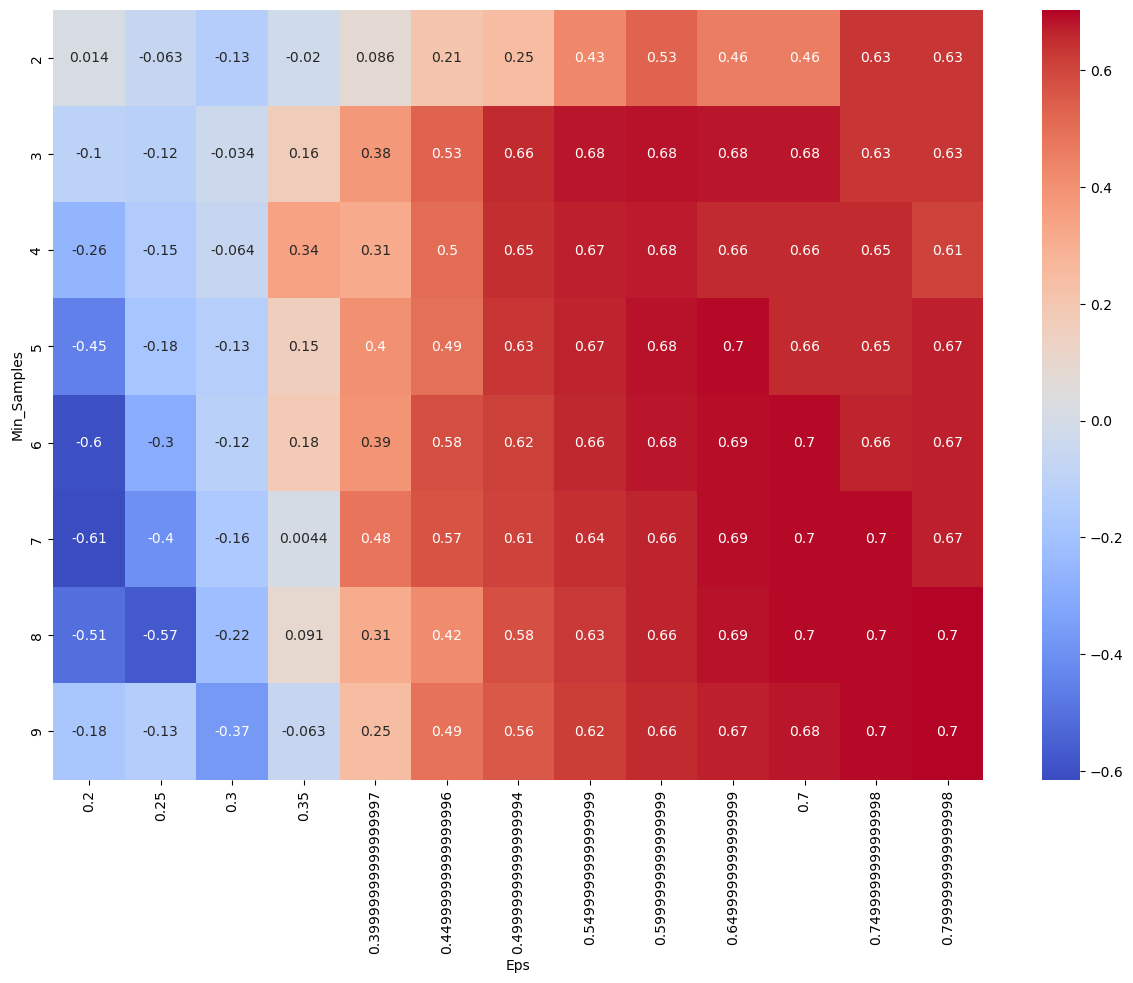

In [79]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data=pivot_data,annot=True,annot_kws={'size':10},
           cmap='coolwarm',ax=ax)
plt.show()

### Evaluando los resultados obtenidos

In [82]:
cluster = DBSCAN(eps=0.65,min_samples=5)
y_pred = cluster.fit_predict(X)
df_blobs['cluster'] = y_pred

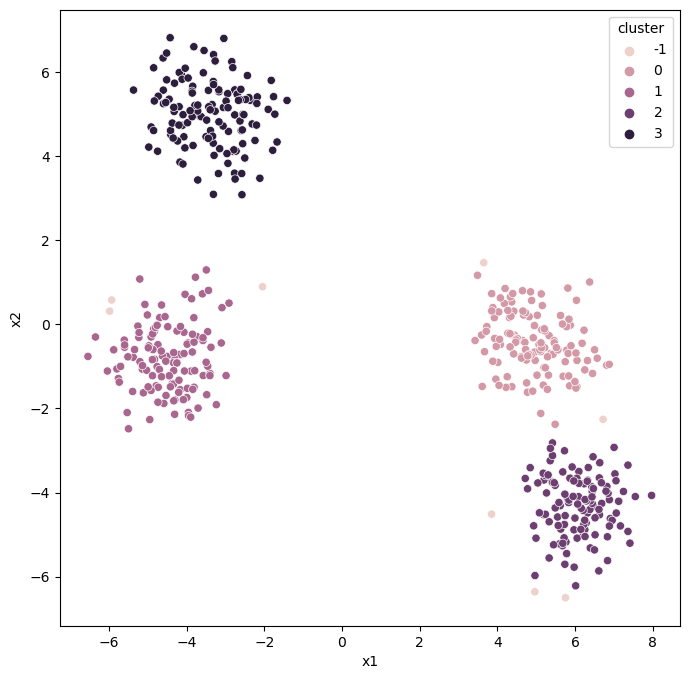

In [83]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2',hue='cluster')
plt.plot()
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.6966789181449651


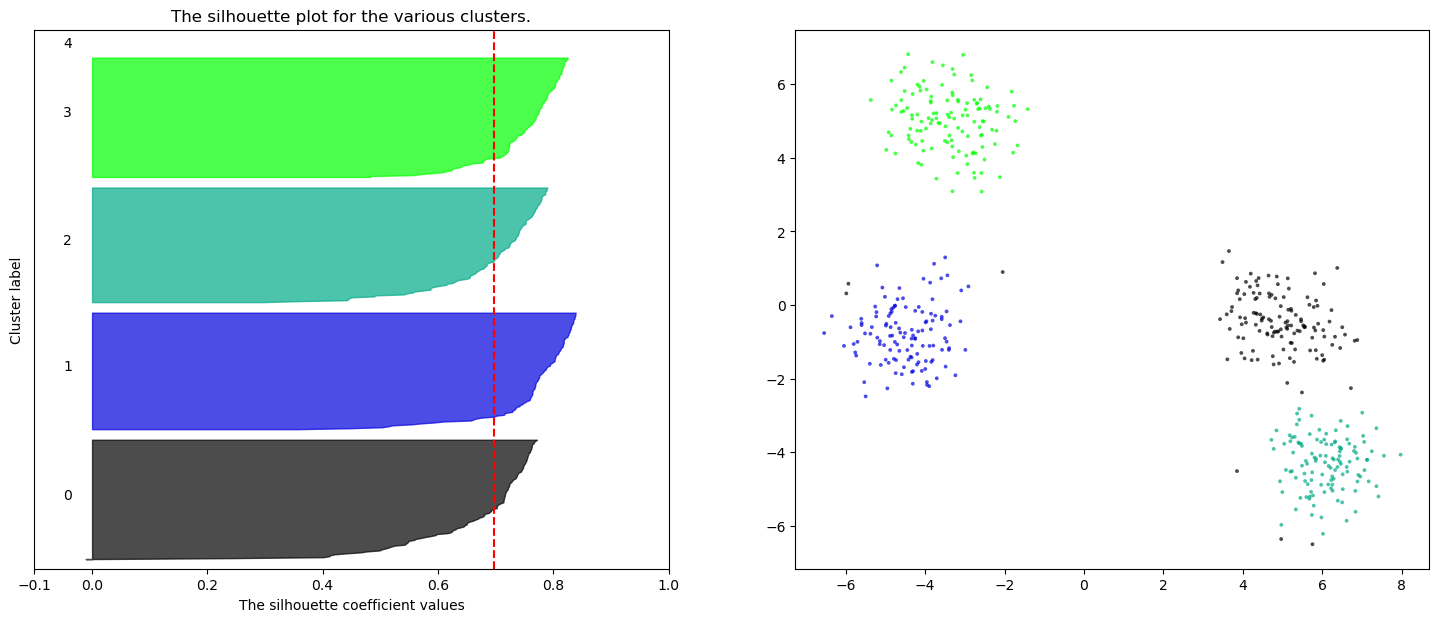

In [89]:
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.

clusterer = DBSCAN(eps=0.65, min_samples=5)
cluster_labels = clusterer.fit_predict(X)
n_clusters = len(np.unique(cluster_labels))

ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)


plt.show()